This notebook performs the synthesis using our proposed synthesization approach applied to the IPUMS data. The synthesis model is a CART. Logistic regression with three way interactions is used as the pMSE model.

In [1]:
from sklearn.mixture import GaussianMixture
import matplotlib.pyplot as plt
import itertools

from bayes_opt import BayesianOptimization
from bayes_opt import UtilityFunction

from helper_functions import *

rng = np.random.RandomState(42)

Import the data.

In [2]:
# import standardized lat/long location data
train = pd.read_csv("../Data/IPUMS/cleaned_ipums_data.csv")

***

In [3]:
train

,incwage,years_of_educ,potential_experience,non_white,sex
0,-0.579435,1.109071,-0.039398,0,1
1,0.564281,0.724424,0.369388,0,0
2,-0.748874,-0.044869,-1.347515,0,0
3,-0.935257,-0.814163,-1.511030,0,0
4,-0.164308,-0.429516,1.186962,1,0
...,...,...,...,...,...
197751,-0.092296,1.109071,-0.448185,0,0
197752,-0.854774,1.109071,-0.611699,0,1
197753,0.521921,1.777461,0.063806,0,0
197754,-0.981853,0.724424,-0.448185,0,1


***

Functions for logistic and multinomial logistic regression synthesizer.

In [4]:
def train_models_mn(#overall parameters
                    train_data,
                    number_synthetic_datasets,
                    # hyperparameters for GMM, end with underscore means Bayesian optimization will choose
                    number_gmm_initializations,
                    num_components_,
                    # hyperparameters for CART, end with underscore means Bayesian optimization will choose
                    C_non_white_,
                    C_sex_):
    
    num_samples = train_data.shape[0]
    
    ########## Code for GMM ############
    
    # fit GMM model
    GMM = GaussianMixture(num_components_, n_init=number_gmm_initializations, init_params="k-means++", random_state=rng).fit(train_data.loc[:,["incwage", "years_of_educ", "potential_experience"]])
    
    # list for synthetic datasets
    sXs = []
    
    # generate and store number_synthetic_datasets synthetic datasets
    for i in range(number_synthetic_datasets):
        sX = GMM.sample(num_samples)[0]
        sX = pd.DataFrame(sX)
        sX.columns = ["incwage", "years_of_educ", "potential_experience"]
        sXs.append(sX)
        
    ####################################################################################################
        
    ########### Code for non-white MN ##########
    
    synth_non_white_vars = multinomial_synthesizer(orig_data=train_data.loc[:,["incwage", "years_of_educ", "potential_experience"]], 
                                                   synth_data_sets=sXs, 
                                                   target=train_data.non_white, 
                                                   penalty_param=C_non_white_)
    
    sXs = [pd.concat([Y, synth_non_white_vars[i]], axis=1) for i,Y in enumerate(sXs)]
        
    ####################################################################################################
        
    ########### Code for sex MN ##########
    
    synth_sex_vars = multinomial_synthesizer(orig_data=train_data.loc[:,["incwage", "years_of_educ", "potential_experience", "non_white"]], 
                                             synth_data_sets=sXs, 
                                             target=train_data.sex, 
                                             penalty_param=C_sex_)
    
    sXs = [pd.concat([Y, synth_sex_vars[i]], axis=1) for i,Y in enumerate(sXs)]
        
    ####################################################################################################
        
    ###### Calculate pMSE ratios ######
    pmse_ratios = [pmse_ratio(train_data, Y) for Y in sXs]
    
    return pmse_ratios, sXs

In [5]:
def optimize_models_mn(train_data,
                       number_synthetic_datasets,
                       number_gmm_initializations,
                       random_state):

    def evaluate_models(num_components_, C_non_white_, C_sex_):

        pmse_ratios, _ = train_models_mn(train_data=train_data,
                                         number_synthetic_datasets=number_synthetic_datasets,
                                         number_gmm_initializations=number_gmm_initializations,
                                         num_components_=int(num_components_),
                                         C_non_white_=C_non_white_,
                                         C_sex_=C_sex_)
        
        return -1 * ((1 - np.mean(pmse_ratios))**2)

    optimizer = BayesianOptimization(
        f=evaluate_models,
        pbounds={
            "num_components_": (10, 200.99),
            "C_non_white_": (0.001, 3),
            "C_sex_": (0.001, 3)
        },
        random_state=random_state)
    
    utility = UtilityFunction(kind="ei", xi=1e-02)
    optimizer.maximize(init_points=5, n_iter=25, acquisition_function=utility)
    print("Final Result: ", optimizer.max)
    return optimizer.max, optimizer

The default value for $\alpha = 1e-06$.

In [6]:
nsd = 10
ngi = 2
random_states = [np.random.RandomState(1006), np.random.RandomState(428)]

In [7]:
optimization_results = [optimize_models_mn(train_data=train, number_synthetic_datasets=nsd, number_gmm_initializations=ngi, random_state=r) for r in random_states]

|   iter    |  target   | C_non_... |  C_sex_   | num_co... |
-------------------------------------------------------------
| 1         | -0.0683   | 2.23      | 0.68      | 132.7     |
| 2         | -0.1942   | 2.647     | 2.222     | 147.8     |
| 3         | -571.6    | 0.8867    | 1.577     | 43.19     |
| 4         | -0.9982   | 2.436     | 2.548     | 58.99     |
| 5         | -72.81    | 0.7125    | 1.376     | 53.72     |
| 6         | -0.02681  | 2.438     | 1.451     | 140.2     |
| 7         | -207.5    | 0.001     | 0.001     | 68.64     |
| 8         | -194.0    | 0.001     | 0.001     | 156.5     |
| 9         | -13.24    | 0.001     | 3.0       | 144.2     |
| 10        | -0.0282   | 3.0       | 3.0       | 123.4     |
| 11        | -172.0    | 0.001     | 0.001     | 114.6     |
| 12        | -11.44    | 0.001     | 3.0       | 128.0     |
| 13        | -92.43    | 3.0       | 0.001     | 127.1     |
| 14        | -12.56    | 0.001     | 3.0       | 135.0     |
| 15    

In [8]:
run_targets = [np.minimum.accumulate(-i[1].space.target) for i in optimization_results]

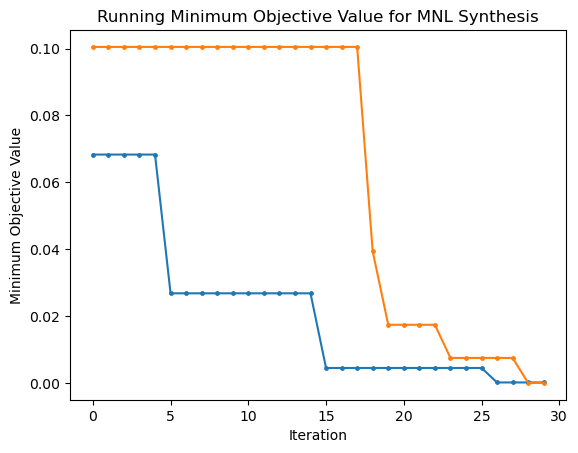

In [9]:
plt.plot(run_targets[0])
plt.scatter(np.arange(len(run_targets[0])), run_targets[0], s=6)
plt.plot(run_targets[1])
plt.scatter(np.arange(len(run_targets[1])), run_targets[1], s=6)
plt.title("Running Minimum Objective Value for MNL Synthesis")
plt.xlabel("Iteration")
plt.ylabel("Minimum Objective Value")
plt.show()

Choose the params that gave the best objective value across all random seeds.

In [10]:
best_params = optimization_results[np.argmax([x[0]['target'] for x in optimization_results])][0]

In [11]:
best_params

{'target': -1.5104277118451726e-05,
 'params': {'C_non_white_': 3.0,
  'C_sex_': 3.0,
  'num_components_': 192.32027882846802}}

Generate 20 synthetic data sets.

On occassion, the synthesis models will produce a significantly different fit than what was observed during the optimization process. In these cases, retrain the models until a fit (judged by the pMSE ratio) consistent with the optimization results is observed.

In [31]:
pmse_ratios, full_sXs = train_models_mn(train_data=train,
                                        number_synthetic_datasets=20,
                                        # hyperparameters for GMM
                                        number_gmm_initializations=ngi,
                                        num_components_=int(best_params['params']['num_components_']),
                                        # hyperparameters for CART, end with underscore means Bayesian optimization will choose
                                        C_non_white_=best_params['params']['C_non_white_'],
                                        C_sex_=best_params['params']['C_sex_'])

In [32]:
np.mean(pmse_ratios)

1.00204204294548

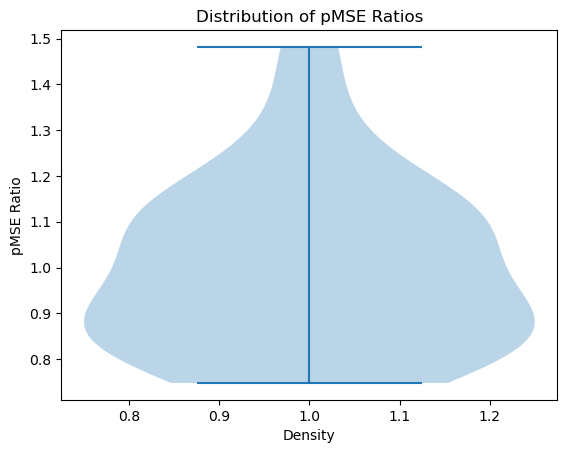

In [33]:
plt.violinplot(pmse_ratios)
plt.xlabel("Density")
plt.ylabel("pMSE Ratio")
plt.title("Distribution of pMSE Ratios")
plt.show()

# Save the synthetic datasets.

In [34]:
for i, sX in enumerate(full_sXs):
    sX.to_csv("../Data/IPUMS/Synthetic Datasets/gmm_and_mnl_" + str(i) + ".csv", index=False)

***